In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

def data_multimodal(n_samples=400, noise_std=0.5, random_state=42):
    # Generate input features
    np.random.seed(random_state)
    X = np.random.uniform(-1.5, 1.5, (n_samples, 5))
    
    # Create a bimodal function by combining two different regimes
    # Based on a threshold condition to create clear separation
    condition = X[:, 0] > 0.5  # Split based on first feature
    
    # Regime 1: For X[:, 0] <= 0
    f1 = -1 + 2 * np.sin(2 * X[:, 0]) + 0.5 * X[:, 1]**2
    
    # Regime 2: For X[:, 0] > 0  
    f2 = 2 + X[:, 0]**2 + 0.3 * X[:, 2] * X[:, 3]
    
    # Combine the two regimes
    true_f = np.where(condition, f2, f1)
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, n_samples)
    y = true_f + noise

    return X, y

X, y = data_multimodal()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

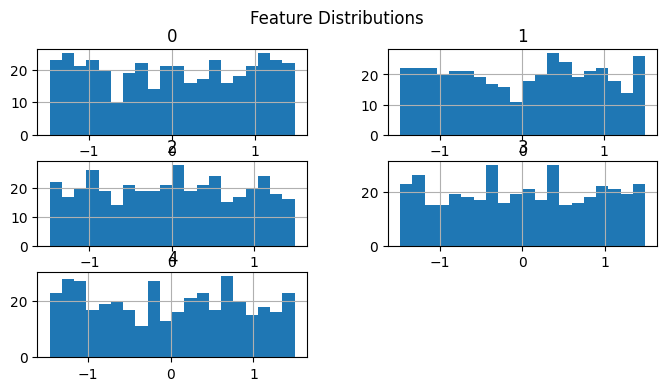

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(8, 4), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

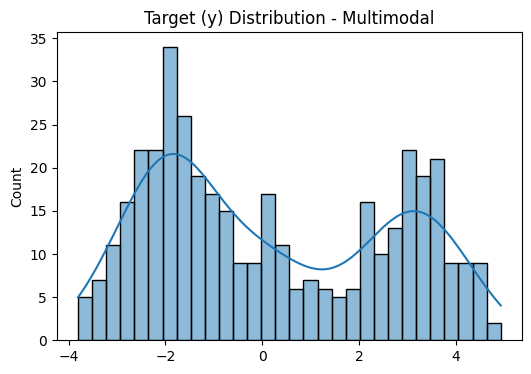

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True, bins=30)
plt.title("Target (y) Distribution - Multimodal")
plt.show()

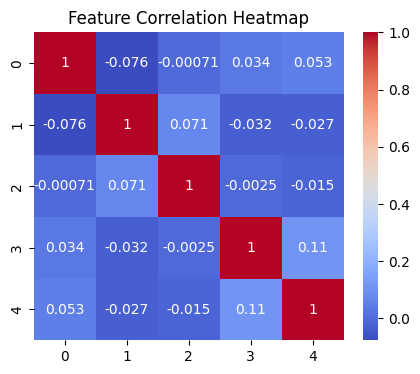

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Iterations: 100%|██████████| 10000/10000 [04:20<00:00, 38.36it/s]


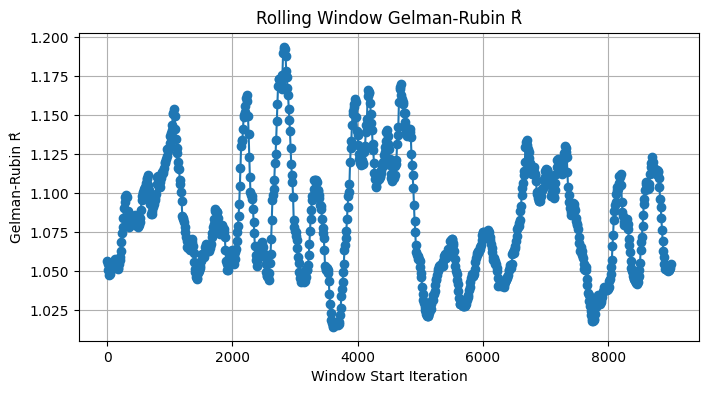

In [8]:
window_size = 1000
step_size = 10
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=10000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
n_samples = chains_array.shape[1]

rhat_list = []
start_list = []

for start in range(0, n_samples - window_size + 1, step_size):
    end = start + window_size
    window_chains = chains_array[:, start:end]
    idata = az.from_dict(posterior={"eps_sigma2": window_chains})
    rhat = az.rhat(idata, var_names=["eps_sigma2"]).to_array().item()
    rhat_list.append(rhat)
    start_list.append(start)

plt.figure(figsize=(8, 4))
plt.plot(start_list, rhat_list, marker='o')
plt.xlabel("Window Start Iteration")
plt.ylabel("Gelman-Rubin R̂")
plt.title("Rolling Window Gelman-Rubin R̂")
plt.grid(True)
plt.show()

Iterations: 100%|██████████| 10000/10000 [00:38<00:00, 260.28it/s]


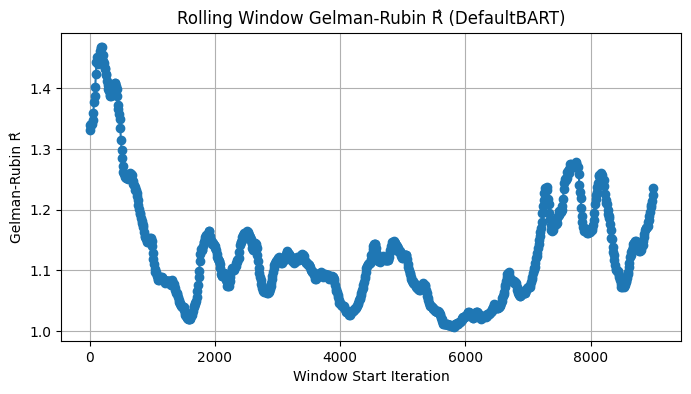

In [9]:
window_size = 1000
step_size = 10
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=10000, nskip=0, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
n_samples = chains_array.shape[1]

rhat_list = []
start_list = []

for start in range(0, n_samples - window_size + 1, step_size):
    end = start + window_size
    window_chains = chains_array[:, start:end]
    idata = az.from_dict(posterior={"eps_sigma2": window_chains})
    rhat = az.rhat(idata, var_names=["eps_sigma2"]).to_array().item()
    rhat_list.append(rhat)
    start_list.append(start)

plt.figure(figsize=(8, 4))
plt.plot(start_list, rhat_list, marker='o')
plt.xlabel("Window Start Iteration")
plt.ylabel("Gelman-Rubin R̂")
plt.title("Rolling Window Gelman-Rubin R̂ (DefaultBART)")
plt.grid(True)
plt.show()